In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
from scipy import signal, fftpack
from scipy.fft import fftshift
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Entire Cut Signals (potentially includes non-stable speed regions)

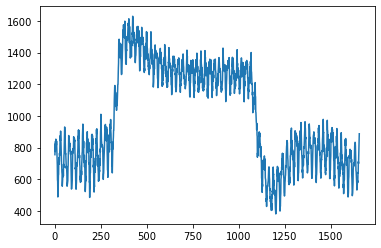

In [38]:
# these are files with the "stable speed" selected
# interim_data_folder = Path('interim_data_sample/')
file_path = Path('23OCT2018.pickle')
# file_path = interim_data_folder / '1568213830_57_0.pickle'

# load pickle
with open(file_path, "rb") as input_file:
    df = pickle.load(input_file)
    df = df['1540298755_54_8']['current_sub'].reset_index(drop=True)
#     df = df['1540298755_15_36']
#     df = df.reset_index(drop=True)
    
# # plot both the main spindle and sub spindle current signals
df.plot()
# df.plot(y=['current_sub'])

df.to_csv('sample_signal.csv')

(828,)
(828,)


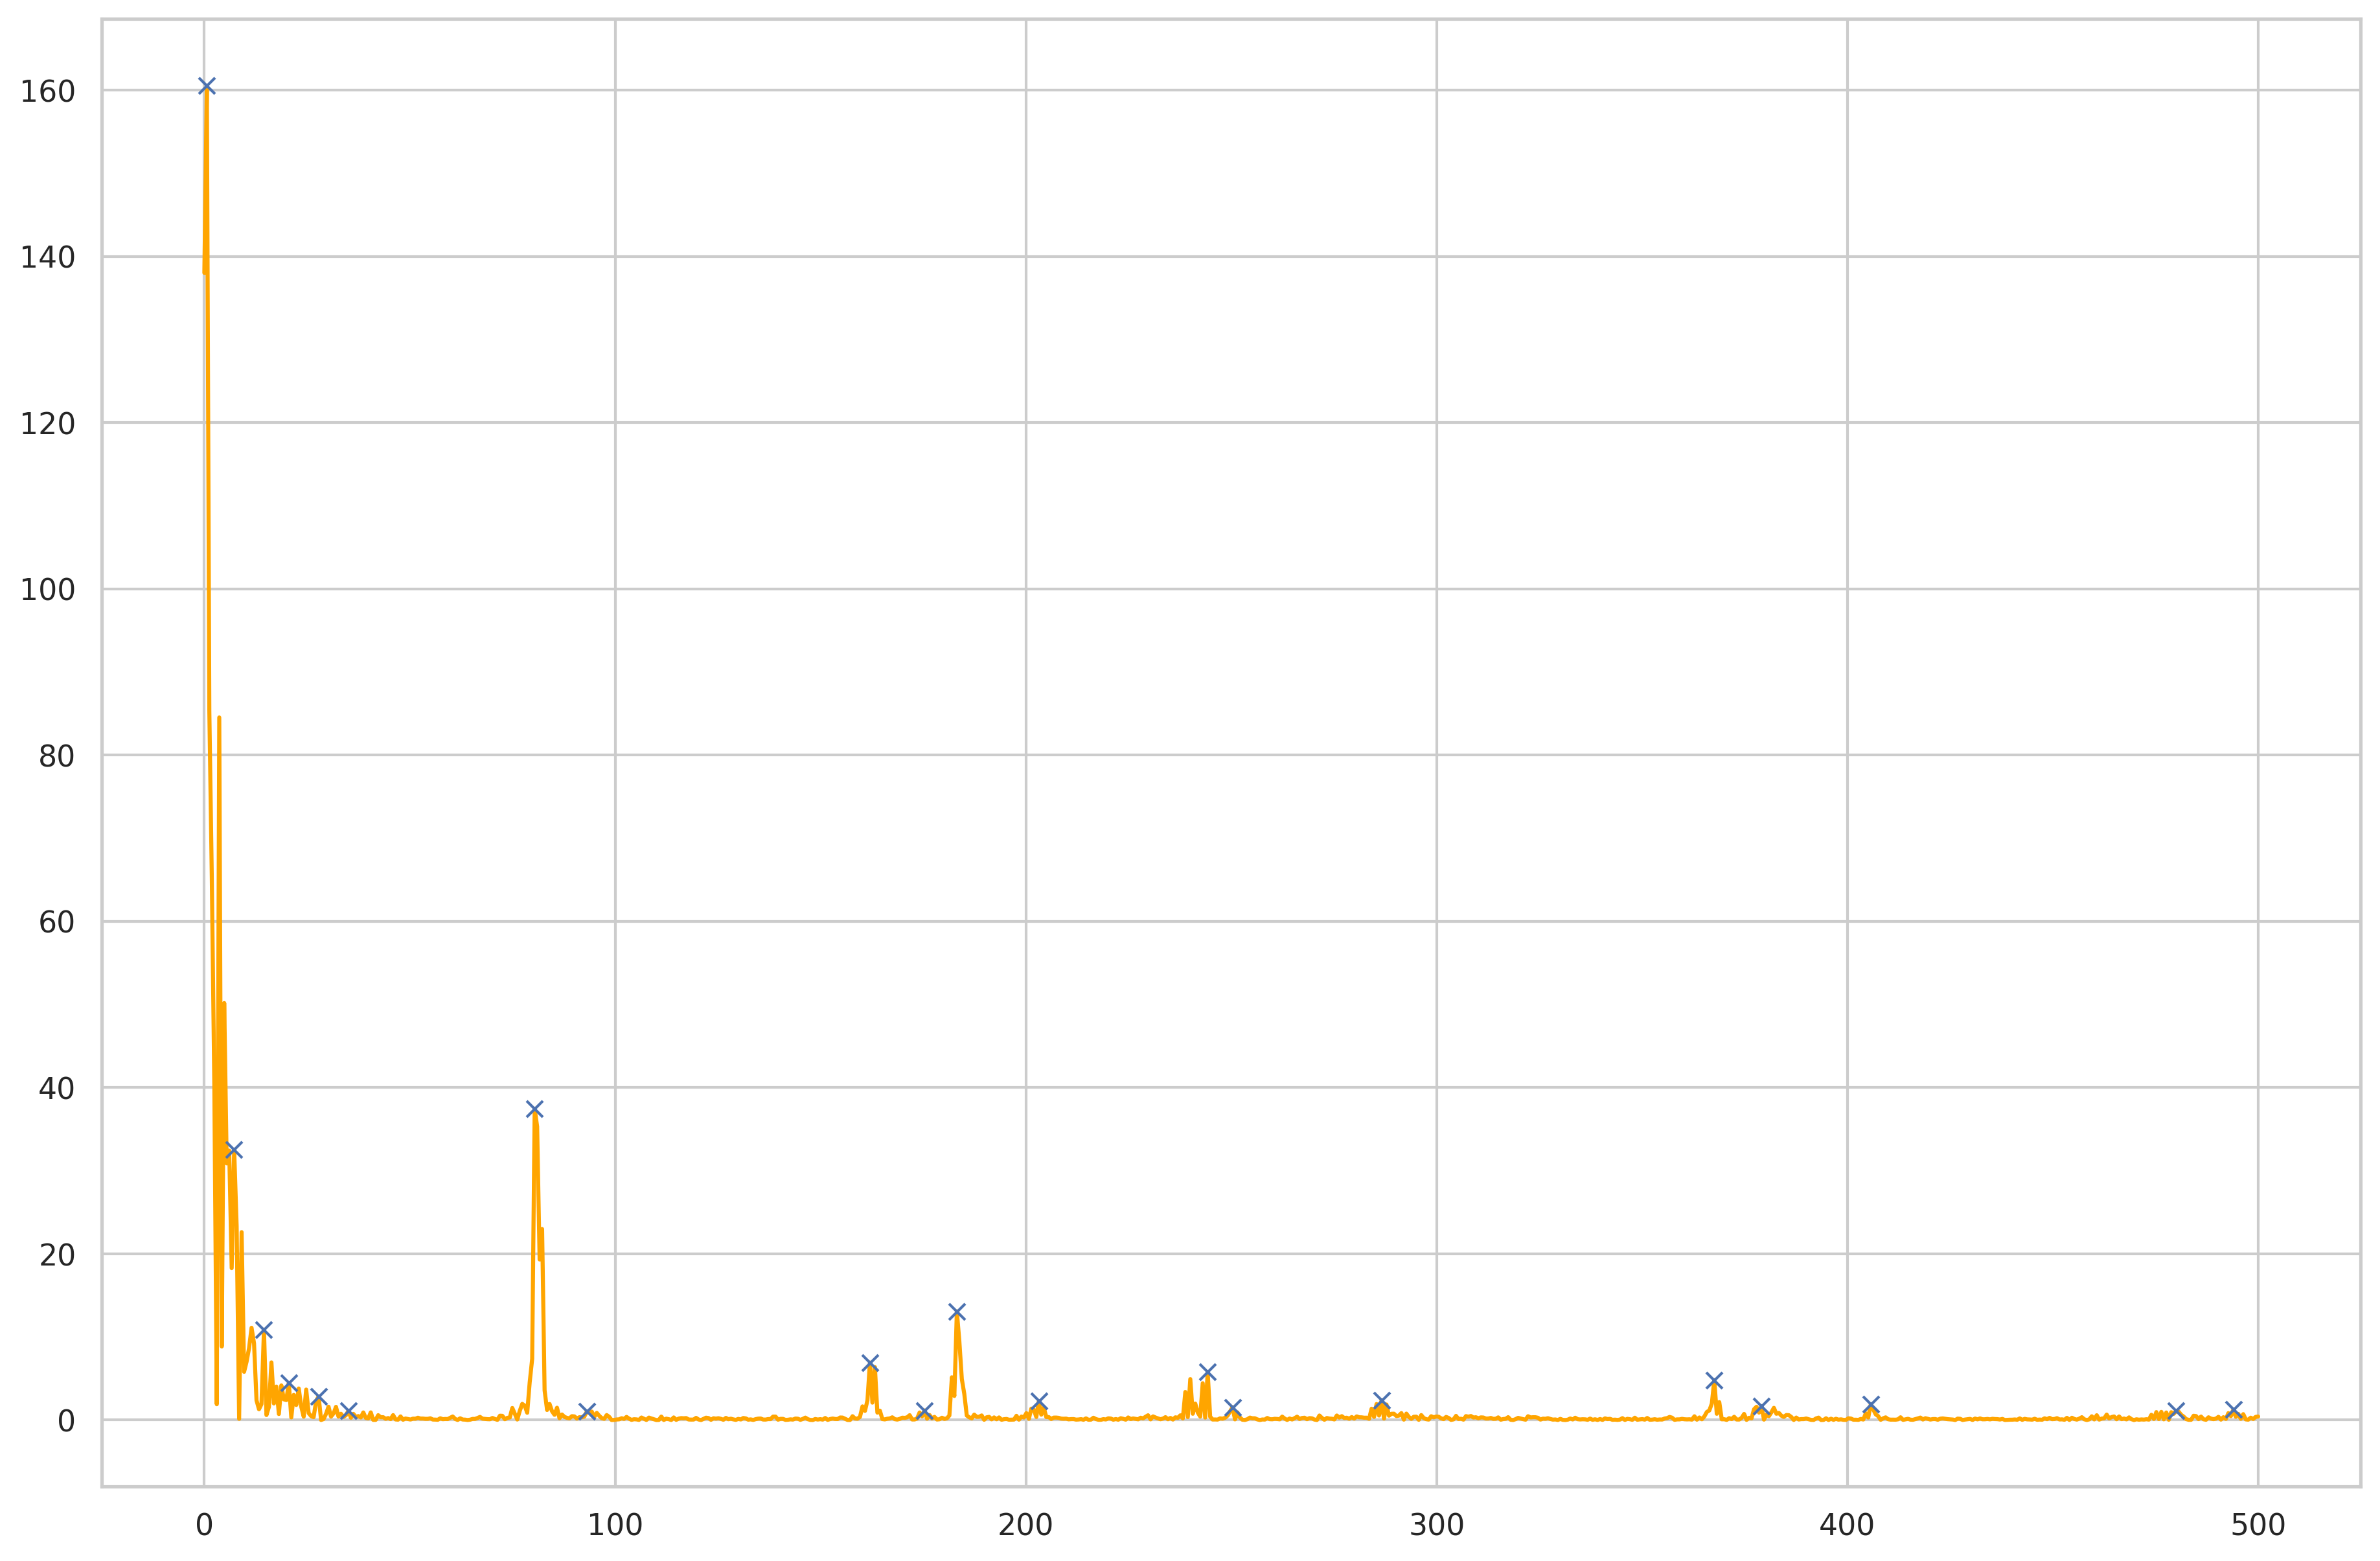

In [41]:
# variable_to_trend = 'Power_SubSpindle'
variable_to_trend = 'current_sub'

y = df[variable_to_trend].to_numpy(dtype='float64')
y = signal.detrend(y,type == 'constant') # Detrended signal
N = len(y) # number of sample points
y *= np.hamming(N) # apply the window
T = 1.0 / 1000.0 # sample spacing
x = np.linspace(0.0, N*T, N)

# frequency of y
yf = fftpack.rfft(y)
yf = 2.0/N * np.abs(yf[:int(N/2.0)])
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
print(yf.shape)
print(xf.shape)

fig, ax = plt.subplots(figsize=(15,10),dpi=300)
ax.plot(xf, yf, color='orange')

peaks, _ = signal.find_peaks(yf, height=1, distance=10)

plt.plot(xf[peaks], yf[peaks], "x")
plt.show()


In [4]:
y.shape

(1250,)

In [31]:
# these are files with the "stable speed" selected
interim_data_folder = Path('interim_data_sample/')
file_path = interim_data_folder / '1548348235_54_5.pickle'
# file_path = interim_data_folder / '1568213830_57_0.pickle'

# load pickle
with open(file_path, "rb") as input_file:
    df = pickle.load(input_file)
    df = df.reset_index(drop=True)
#     df = df.reset_index(drop=True)

In [32]:
df.head()

,current_main,current_sub,cut_signal,tool_no,tcmd_z
0,318,545,1.0,54,0.370777
1,293,493,1.0,54,0.851414
2,320,483,1.0,54,-0.013732
3,347,519,1.0,54,-0.384510
4,301,549,1.0,54,0.947542


In [33]:
df = df['current_sub']
df = df.rename('current')
df.to_csv('current.csv')

## Make Plot

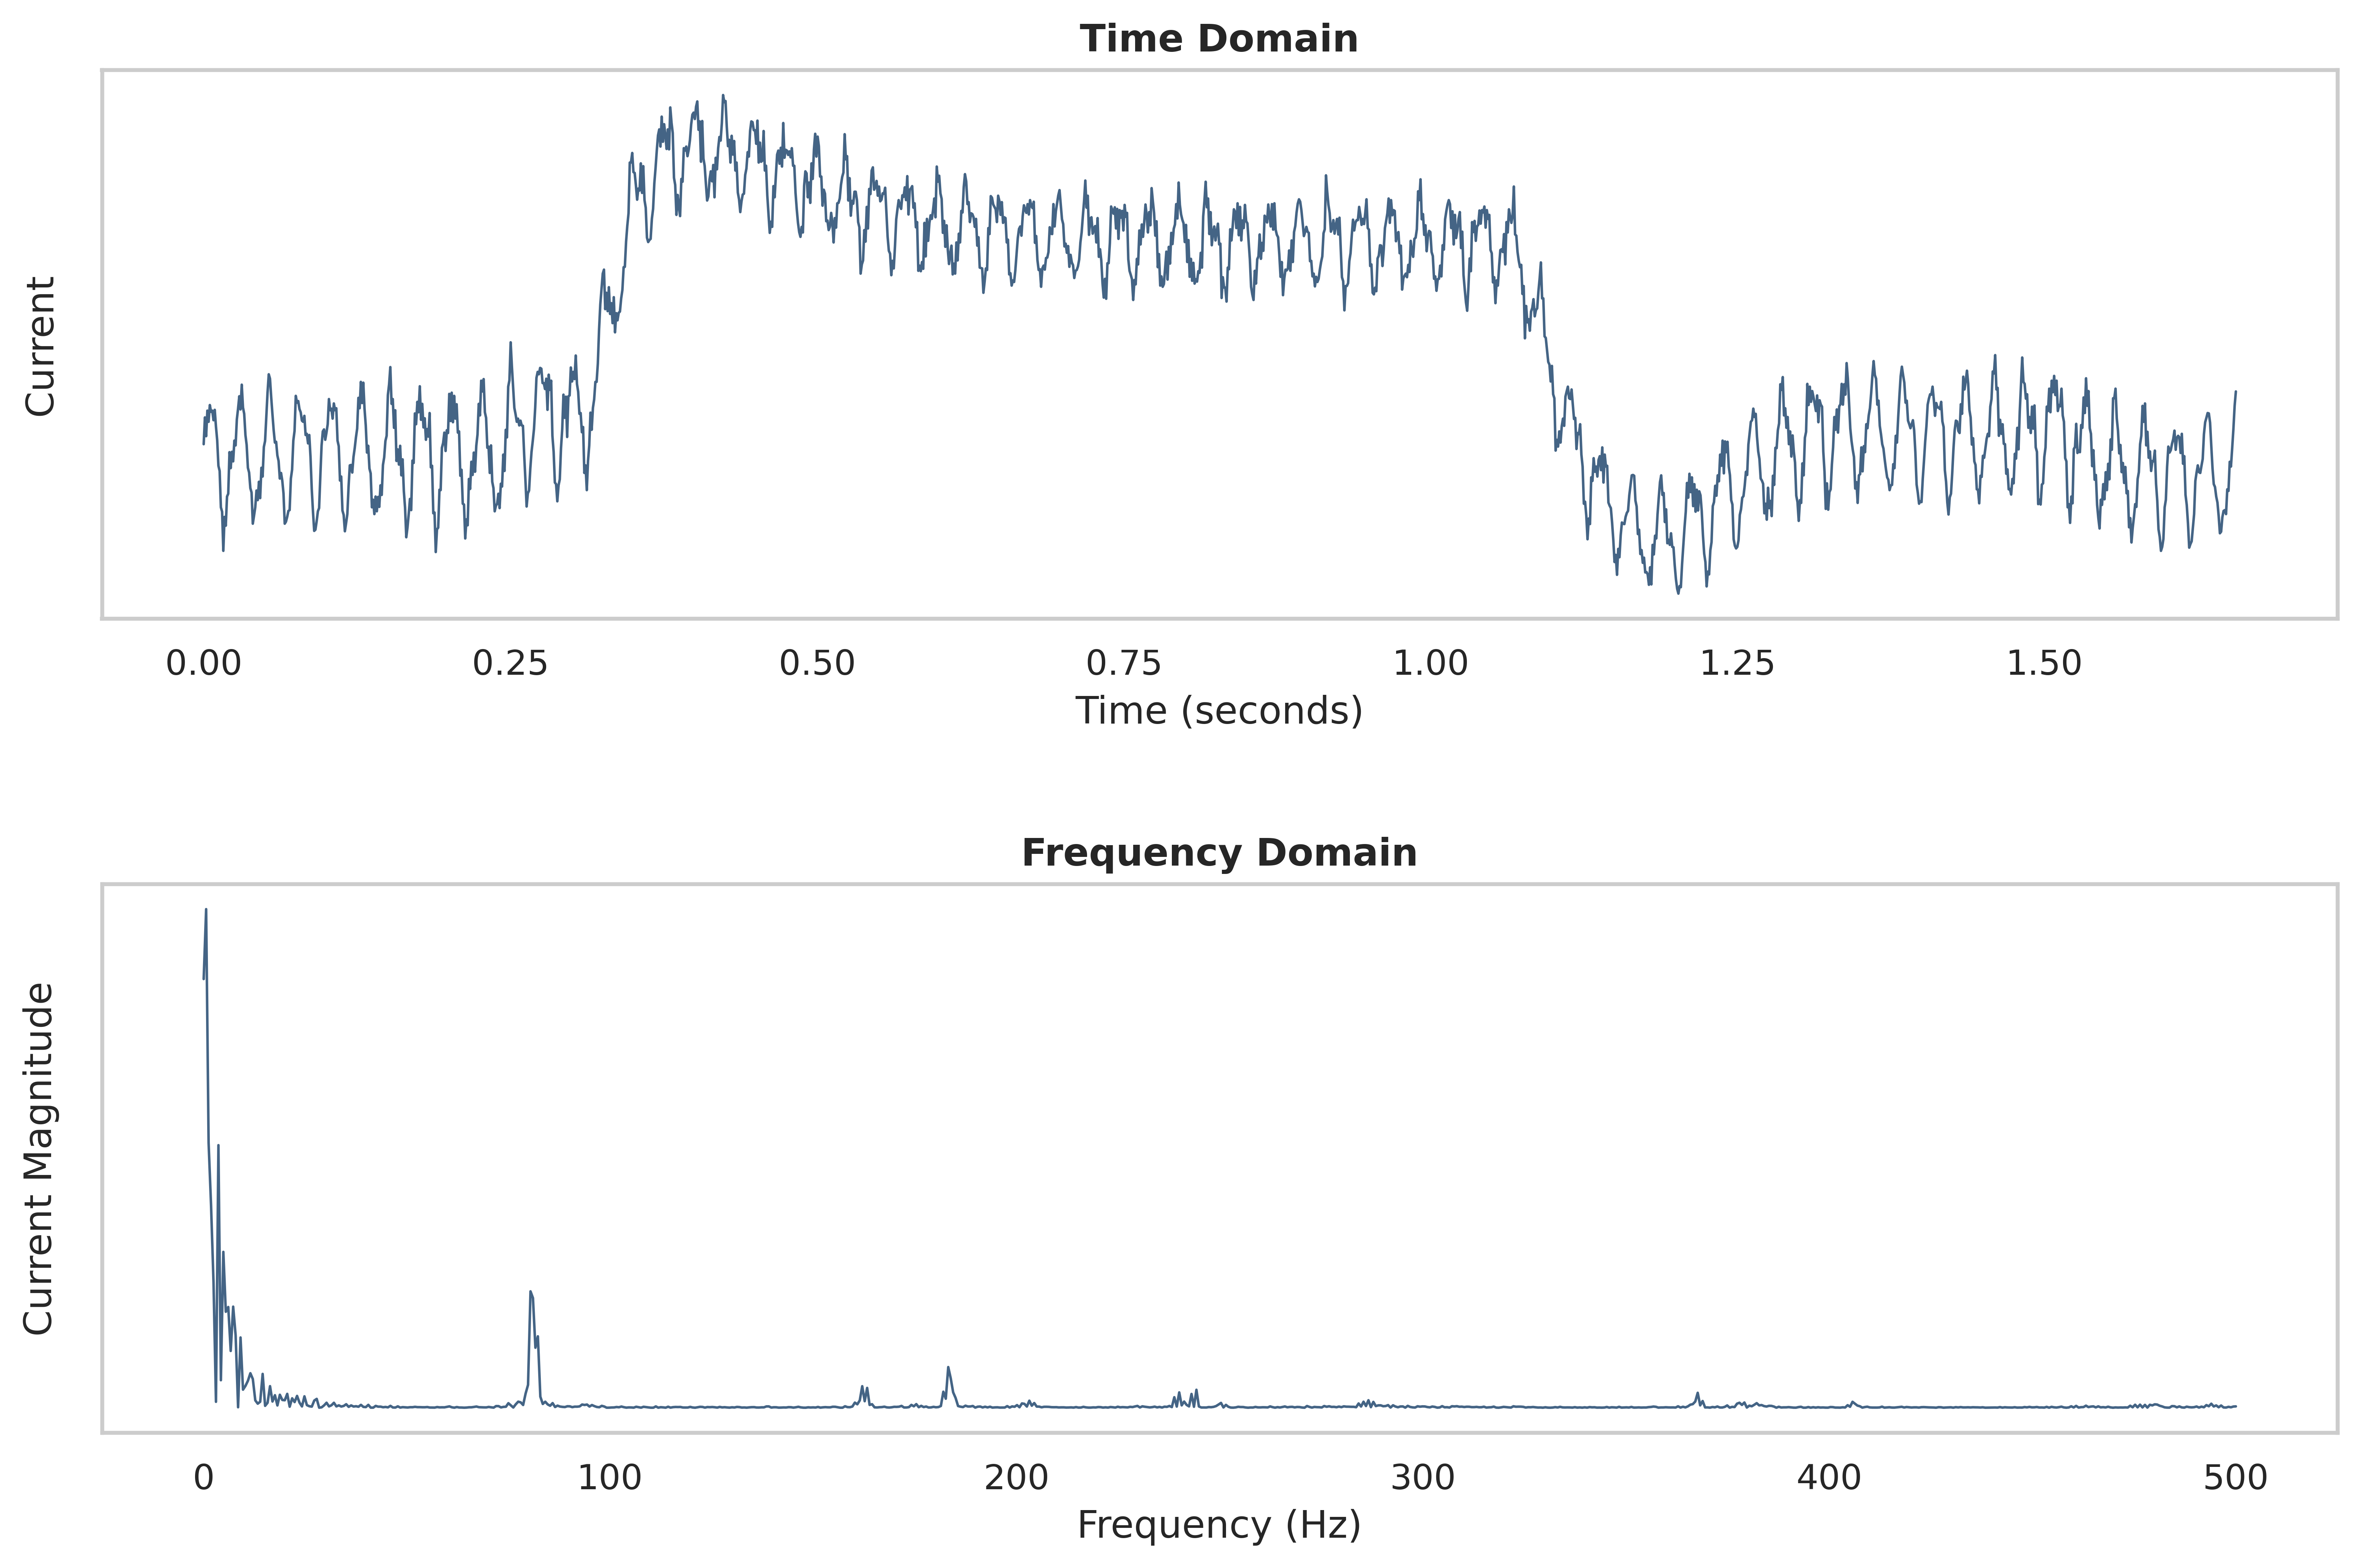

In [42]:
# these are files with the "stable speed" selected
# interim_data_folder = Path('interim_data_sample/')
# file_path = interim_data_folder / '1548348235_54_5.pickle'
# # file_path = interim_data_folder / '1568213830_57_0.pickle'

# # load pickle
# with open(file_path, "rb") as input_file:
#     df = pickle.load(input_file)
#     df = df.reset_index(drop=True)
# #     df = df.reset_index(drop=True)

# df = pd.read_csv('sample_signal.csv')

sns.set(font_scale=1.0,style='whitegrid')

fig, axes = plt.subplots(2, 1, figsize=(12,8), sharex=False, sharey=False,dpi=600)
fig.tight_layout(pad=5.0)

pal = sns.cubehelix_palette(6, rot=-.25, light=.7)

variable_to_trend = 'current_sub'

y = df[variable_to_trend].to_numpy(dtype='float64')
N = len(y) # number of sample points
x = np.linspace(0.0, N*T, N)

axes[0].plot(x, y, marker='', label='Best model', color=pal[3], linewidth=0.8)
axes[0].set_title('Time Domain',fontdict={'fontweight':'semibold'})
axes[0].set_xlabel('Time (seconds)')
axes[0].set_ylabel('Current')
axes[0].set_yticklabels([])


y = signal.detrend(y,type == 'constant') # Detrended signal

y *= np.hamming(N) # apply the window
T = 1.0 / 1000.0 # sample spacing


# frequency of y
yf = fftpack.rfft(y)
yf = 2.0/N * np.abs(yf[:int(N/2.0)])
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

peaks, _ = signal.find_peaks(yf, height=1, distance=10)
    

axes[1].plot(xf, yf, marker='', label='Best model', color=pal[3], linewidth=0.8,)

axes[1].set_title('Frequency Domain',fontdict={'fontweight':'semibold'})
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Current Magnitude')
axes[1].set_yticklabels([])

# axes[1].plot(xf[peaks], yf[peaks], "x")

for ax in axes.flatten():
#     ax.xaxis.set_tick_params(labelbottom=True)
    ax.yaxis.set_tick_params(labelleft=True, which='major')
    ax.grid(False)    
    
# sns.despine(left=True, bottom=True)
# plt.savefig('time_freq_domains.pdf',dpi=600,bbox_inches = "tight")
plt.show()

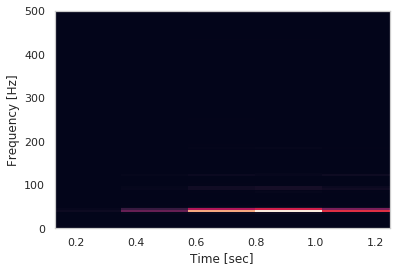

In [7]:
fs = 1000

with open(file_path, "rb") as input_file:
    df = pickle.load(input_file)
    df = df.reset_index(drop=True)[400:1900]

y = df[variable_to_trend].to_numpy(dtype='float64')

y = signal.detrend(y,type == 'constant') # Detrended signal
y *= np.hamming(N) # apply the window
N = len(y) # number of sample points
x = np.linspace(0.0, N*T, N)

f, t, Sxx = signal.spectrogram(y, fs)
plt.pcolormesh(t, f, Sxx,)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

## Try SVD

In [43]:
def trajectory_matrix(s, window_size):
    """Create a trajectory matrix, that will be used forcalculating the SVD. 
    
    The trajectory matrix is also implemented in paper by Liu et al. 2014,
    http://bit.ly/2tvXp9A   

    Parameters
    ===========
    s : numpy array
        The numpy array of the signal

    window_size : int
        The size of the window that you want the trajectory matrix to go
        over.

    Returns
    ===========
    a : numpy array
        Returns the numpy array trajectory matrix

    """

    # resize time series so it is divisible by window size
    s = s[0 : (s.shape[0] - s.shape[0] % window_size)]

    k = len(s) - window_size

    a = np.zeros((k, window_size))

    for i in range(k):
        a[i] = s[i : i + window_size]

    return a

In [44]:
# # these are files with the "stable speed" selected
# interim_data_folder = Path('interim_data_sample/')
# file_path = interim_data_folder / '1548348235_54_5.pickle'
# # file_path = interim_data_folder / '1568213830_57_0.pickle'

# # load pickle
# with open(file_path, "rb") as input_file:
#     df = pickle.load(input_file)
# #     df = df.reset_index(drop=True)[400:1900]
#     df = df.reset_index(drop=True)



N = len(df)
t = np.arange(0,N)
L = 70 # The window length.
K = N - L + 1 # The number of columns in the trajectory matrix.

variable_to_trend = 'current_sub'
F = df[variable_to_trend].to_numpy(dtype='float64')

# Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns.
X = np.column_stack([F[i:i+L] for i in range(0,K)])



# X = trajectory_matrix(F, L)

In [45]:
X.shape

(70, 1587)

In [46]:
d = np.linalg.matrix_rank(X) # The intrinsic dimensionality of the trajectory space.

# For those interested in how to code up an SVD calculation, Numerical Recipes in Fortran 77
# has you covered: http://www.aip.de/groups/soe/local/numres/bookfpdf/f2-6.pdf
# Thankfully, we'll leave the actual SVD calculation to NumPy.
U, Sigma, V = np.linalg.svd(X)
V = V.T # Note: the SVD routine returns V^T, not V, so I'll tranpose it back here. This may seem pointless, 
# but I'll treat the Python representation of V consistently with the mathematical notation in this notebook.

# Calculate the elementary matrices of X, storing them in a multidimensional NumPy array.
# This requires calculating sigma_i * U_i * (V_i)^T for each i, or sigma_i * outer_product(U_i, V_i). 
# Note that Sigma is a 1D array of singular values, instead of the full L x K diagonal matrix.
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

# Quick sanity check: the sum of all elementary matrices in X_elm should be equal to X, to within a 
# *very small* tolerance:
if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

In [47]:
def Hankelise(X):
    """
    Hankelises the matrix X, returning H(X).
    """
    L, K = X.shape
    transpose = False
    if L > K:
        # The Hankelisation below only works for matrices where L < K.
        # To Hankelise a L > K matrix, first swap L and K and tranpose X.
        # Set flag for HX to be transposed before returning. 
        X = X.T
        L, K = K, L
        transpose = True

    HX = np.zeros((L,K))
    
    # I know this isn't very efficient...
    for m in range(L):
        for n in range(K):
            s = m+n
            if 0 <= s <= L-1:
                for l in range(0,s+1):
                    HX[m,n] += 1/(s+1)*X[l, s-l]    
            elif L <= s <= K-1:
                for l in range(0,L-1):
                    HX[m,n] += 1/(L-1)*X[l, s-l]
            elif K <= s <= K+L-2:
                for l in range(s-K+1,L):
                    HX[m,n] += 1/(K+L-s-1)*X[l, s-l]
    if transpose:
        return HX.T
    else:
        return HX
    
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

In [48]:
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

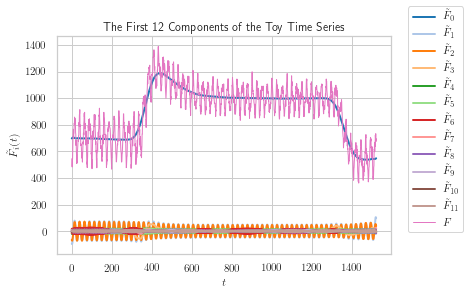

In [65]:
n = min(12,d) # In case of noiseless time series with d < 12.

# Fiddle with colour cycle - need more colours!
fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

# Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
for i in range(n):
    F_i = X_to_TS(X_elem[i])
    fig.axes.plot(t, F_i, lw=2)

fig.axes.plot(t, F, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
fig.set_title("The First 12 Components of the Toy Time Series")
fig.legend(legend, loc=(1.05,0.1));



In [49]:
import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

<ipython-input-49-05fc9baf44d5>:3: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


1
2
3
4
5
6
7


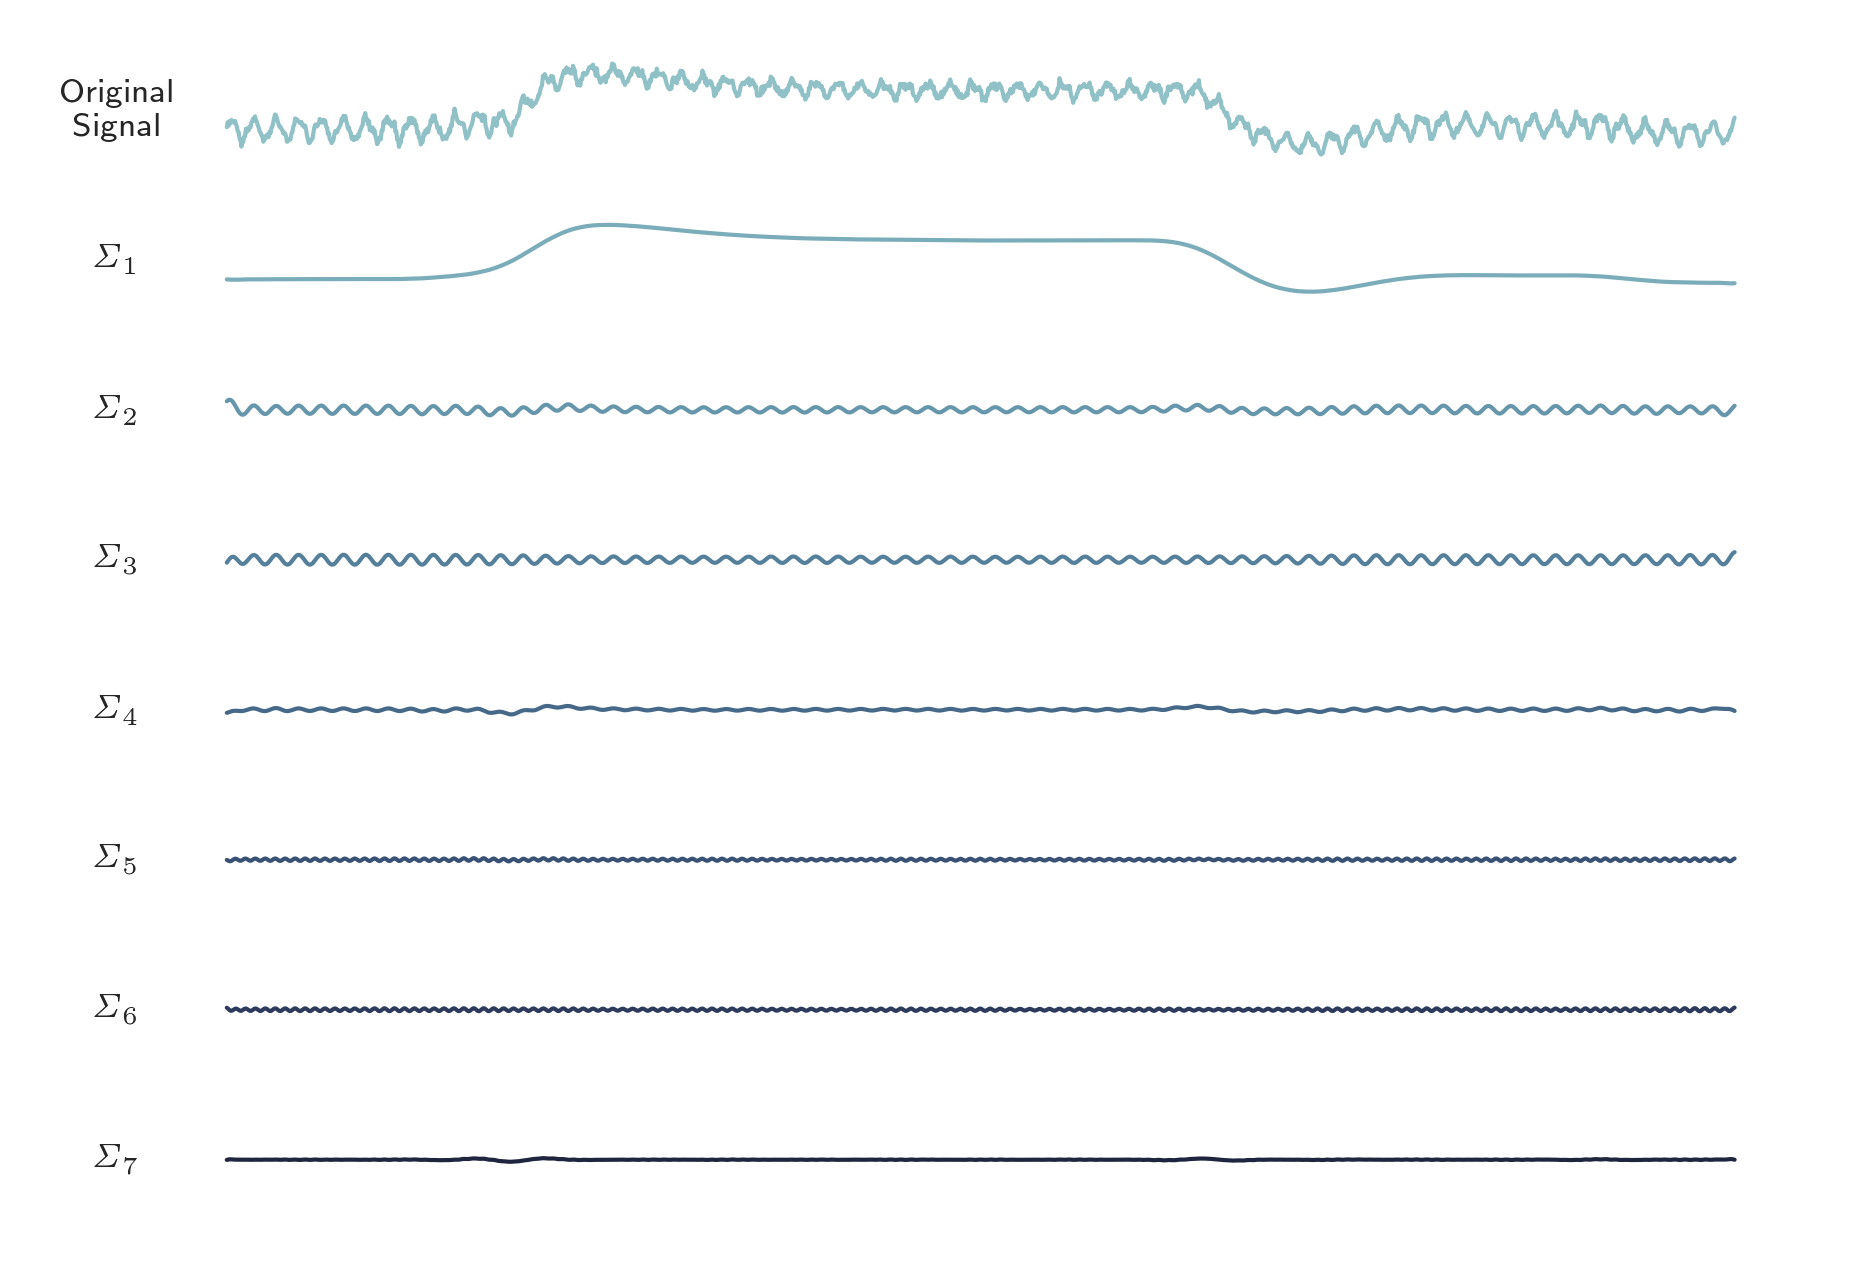

In [50]:
def plot_cut(X_elem, F):
    
    no_signals_to_plot = 7
    sub_fig_no = no_signals_to_plot +1
    # define colour palette and seaborn style
    pal = sns.cubehelix_palette(sub_fig_no, rot=-.25, light=.7)
    sns.set(style="white", context="notebook")
    
    fig, axes = plt.subplots(sub_fig_no, 1,dpi=600, figsize=(3,2), sharex=True, sharey=True, constrained_layout=True,)
    
    # the "revised" signal names so it looks good on the chart
#     signal_names_revised = ['AE Spindle', 
#                         'AE Table','Vibe Spindle',
#                         'Vibe Table','DC Current','AC Current']

    # go through each of the signals
    
    for i in range(sub_fig_no):
        if i == 0:
            F = F - np.average(F)
            axes[i].plot(F,color=pal[i],linewidth=0.5, alpha=1)
            axis_label = "Original\nSignal"
            axes[i].set_ylabel(axis_label,fontsize=4,ma='center', 
                               horizontalalignment='center', verticalalignment='center').set_rotation(0)


            axes[i].spines["top"].set_visible(False)
            axes[i].spines["right"].set_visible(False)
            axes[i].spines["left"].set_visible(False)
            axes[i].spines["bottom"].set_visible(False)
            axes[i].set_xticks([])
            axes[i].set_yticks([])

            
        else:
            print(i)
            
            F_i = X_to_TS(X_elem[i-1])
            F_i = F_i - np.average(F_i)
            axes[i].plot(F_i,color=pal[i],linewidth=0.5, alpha=1)
            axis_label = r"$\mathit{\Sigma}$"+r"$_{%s}$" %i
            axes[i].set_ylabel(axis_label,fontsize=4,).set_rotation(0)
            axes[i].set_ylabel(axis_label,fontsize=4,ma='center', 
                   horizontalalignment='center', verticalalignment='center').set_rotation(0)


            axes[i].spines["top"].set_visible(False)
            axes[i].spines["right"].set_visible(False)
            axes[i].spines["left"].set_visible(False)
            axes[i].spines["bottom"].set_visible(False)
            axes[i].set_xticks([])
            axes[i].set_yticks([])
#             axes[i].grid(alpha=0.5,linewidth=0.5)

    
#     fig.suptitle('Cut Number {}'.format(cut_no), fontsize=8)
    
    
#     pic_dir = pathlib.PurePath() / '_pics'
#     pic_dir = pathlib.PurePath() / '_figures_journal'
    NAME = "ssa_recon.pdf"
    plt.savefig(NAME,dpi=1000,bbox_inches = "tight")
    plt.show()
#     file_path = pic_dir / NAME

#     plt.cla()
#     plt.close(fig)
#     print('Save cut no {}'.format(cut_no))
    
# signals_trend = list(l[7:]) # there are 6 types of signals, smcAC to AE_spindle
# signals_trend = signals_trend[::-1] # reverse the signal order so that it is matching other charts
# # cut_signal = data[0,145] 

plot_cut(X_elem, F)
# plt.savefig("ssa_recon.pdf",quality=100,format='pdf')
# plt.show()

In [169]:
# use numpy linalg.svd to find the singular values
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html
singular_vals = np.linalg.svd(x, full_matrices=False)

In [170]:
singular_vals

(array([[-0.02317656,  0.016306  , -0.03631596, ..., -0.03526557,
          0.02035109, -0.00176141],
        [-0.02329558,  0.00460176, -0.03893236, ...,  0.00108356,
         -0.01426076, -0.01143584],
        [-0.02340562, -0.00719006, -0.03847936, ...,  0.02273775,
         -0.01097974,  0.02846695],
        ...,
        [-0.0201216 ,  0.03803987,  0.01338732, ...,  0.00162434,
          0.00137317,  0.01281821],
        [-0.02013724,  0.0398295 ,  0.00353849, ..., -0.01141166,
          0.0088412 , -0.00325114],
        [-0.02017213,  0.03876407, -0.00646804, ...,  0.00305225,
         -0.0057267 , -0.00846027]]),
 array([220192.29118232,  16553.15168276,  16344.05634803,   4726.18597956,
          4556.7582867 ,   3960.26665788,   2900.47299078,   2730.59953327,
          2552.3807525 ,   1782.73571885,   1744.14811856,   1426.69700809,
          1232.82866314,   1200.57593442,   1124.52878146,   1122.72150685,
          1082.35899861,   1056.57523466,    780.59876311,    775.538

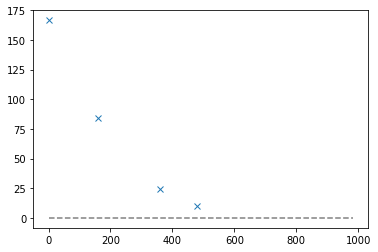

In [61]:
from scipy.signal import find_peaks

peaks, _ = find_peaks(yf, height=10, distance=30)
plt.plot(peaks, yf[peaks], "x")
plt.plot(np.zeros_like(yf), "--", color="gray")

In [47]:
peaks

array([   2,    4,    7,   13,   15,   17,   22,   24,   33,   35,   40,
         42,   51,   53,   55,   60,   62,   71,   73,   75,   79,   81,
         83,   85,   89,   93,   95,   98,  101,  103,  105,  111,  113,
        115,  117,  119,  121,  123,  125,  127,  129,  131,  133,  135,
        137,  139,  141,  143,  145,  147,  151,  153,  160,  162,  164,
        166,  168,  170,  172,  174,  176,  178,  180,  182,  184,  186,
        188,  190,  192,  194,  196,  198,  200,  204,  206,  210,  212,
        214,  216,  218,  222,  224,  226,  230,  232,  234,  236,  244,
        246,  248,  254,  258,  268,  292,  294,  310,  320,  322,  324,
        326,  328,  330,  332,  334,  336,  340,  342,  344,  350,  352,
        354,  358,  361,  363,  365,  367,  369,  371,  373,  375,  377,
        379,  381,  383,  385,  387,  389,  391,  393,  396,  398,  401,
        403,  405,  407,  409,  411,  415,  417,  419,  421,  423,  425,
        427,  429,  431,  433,  435,  437,  439,  4

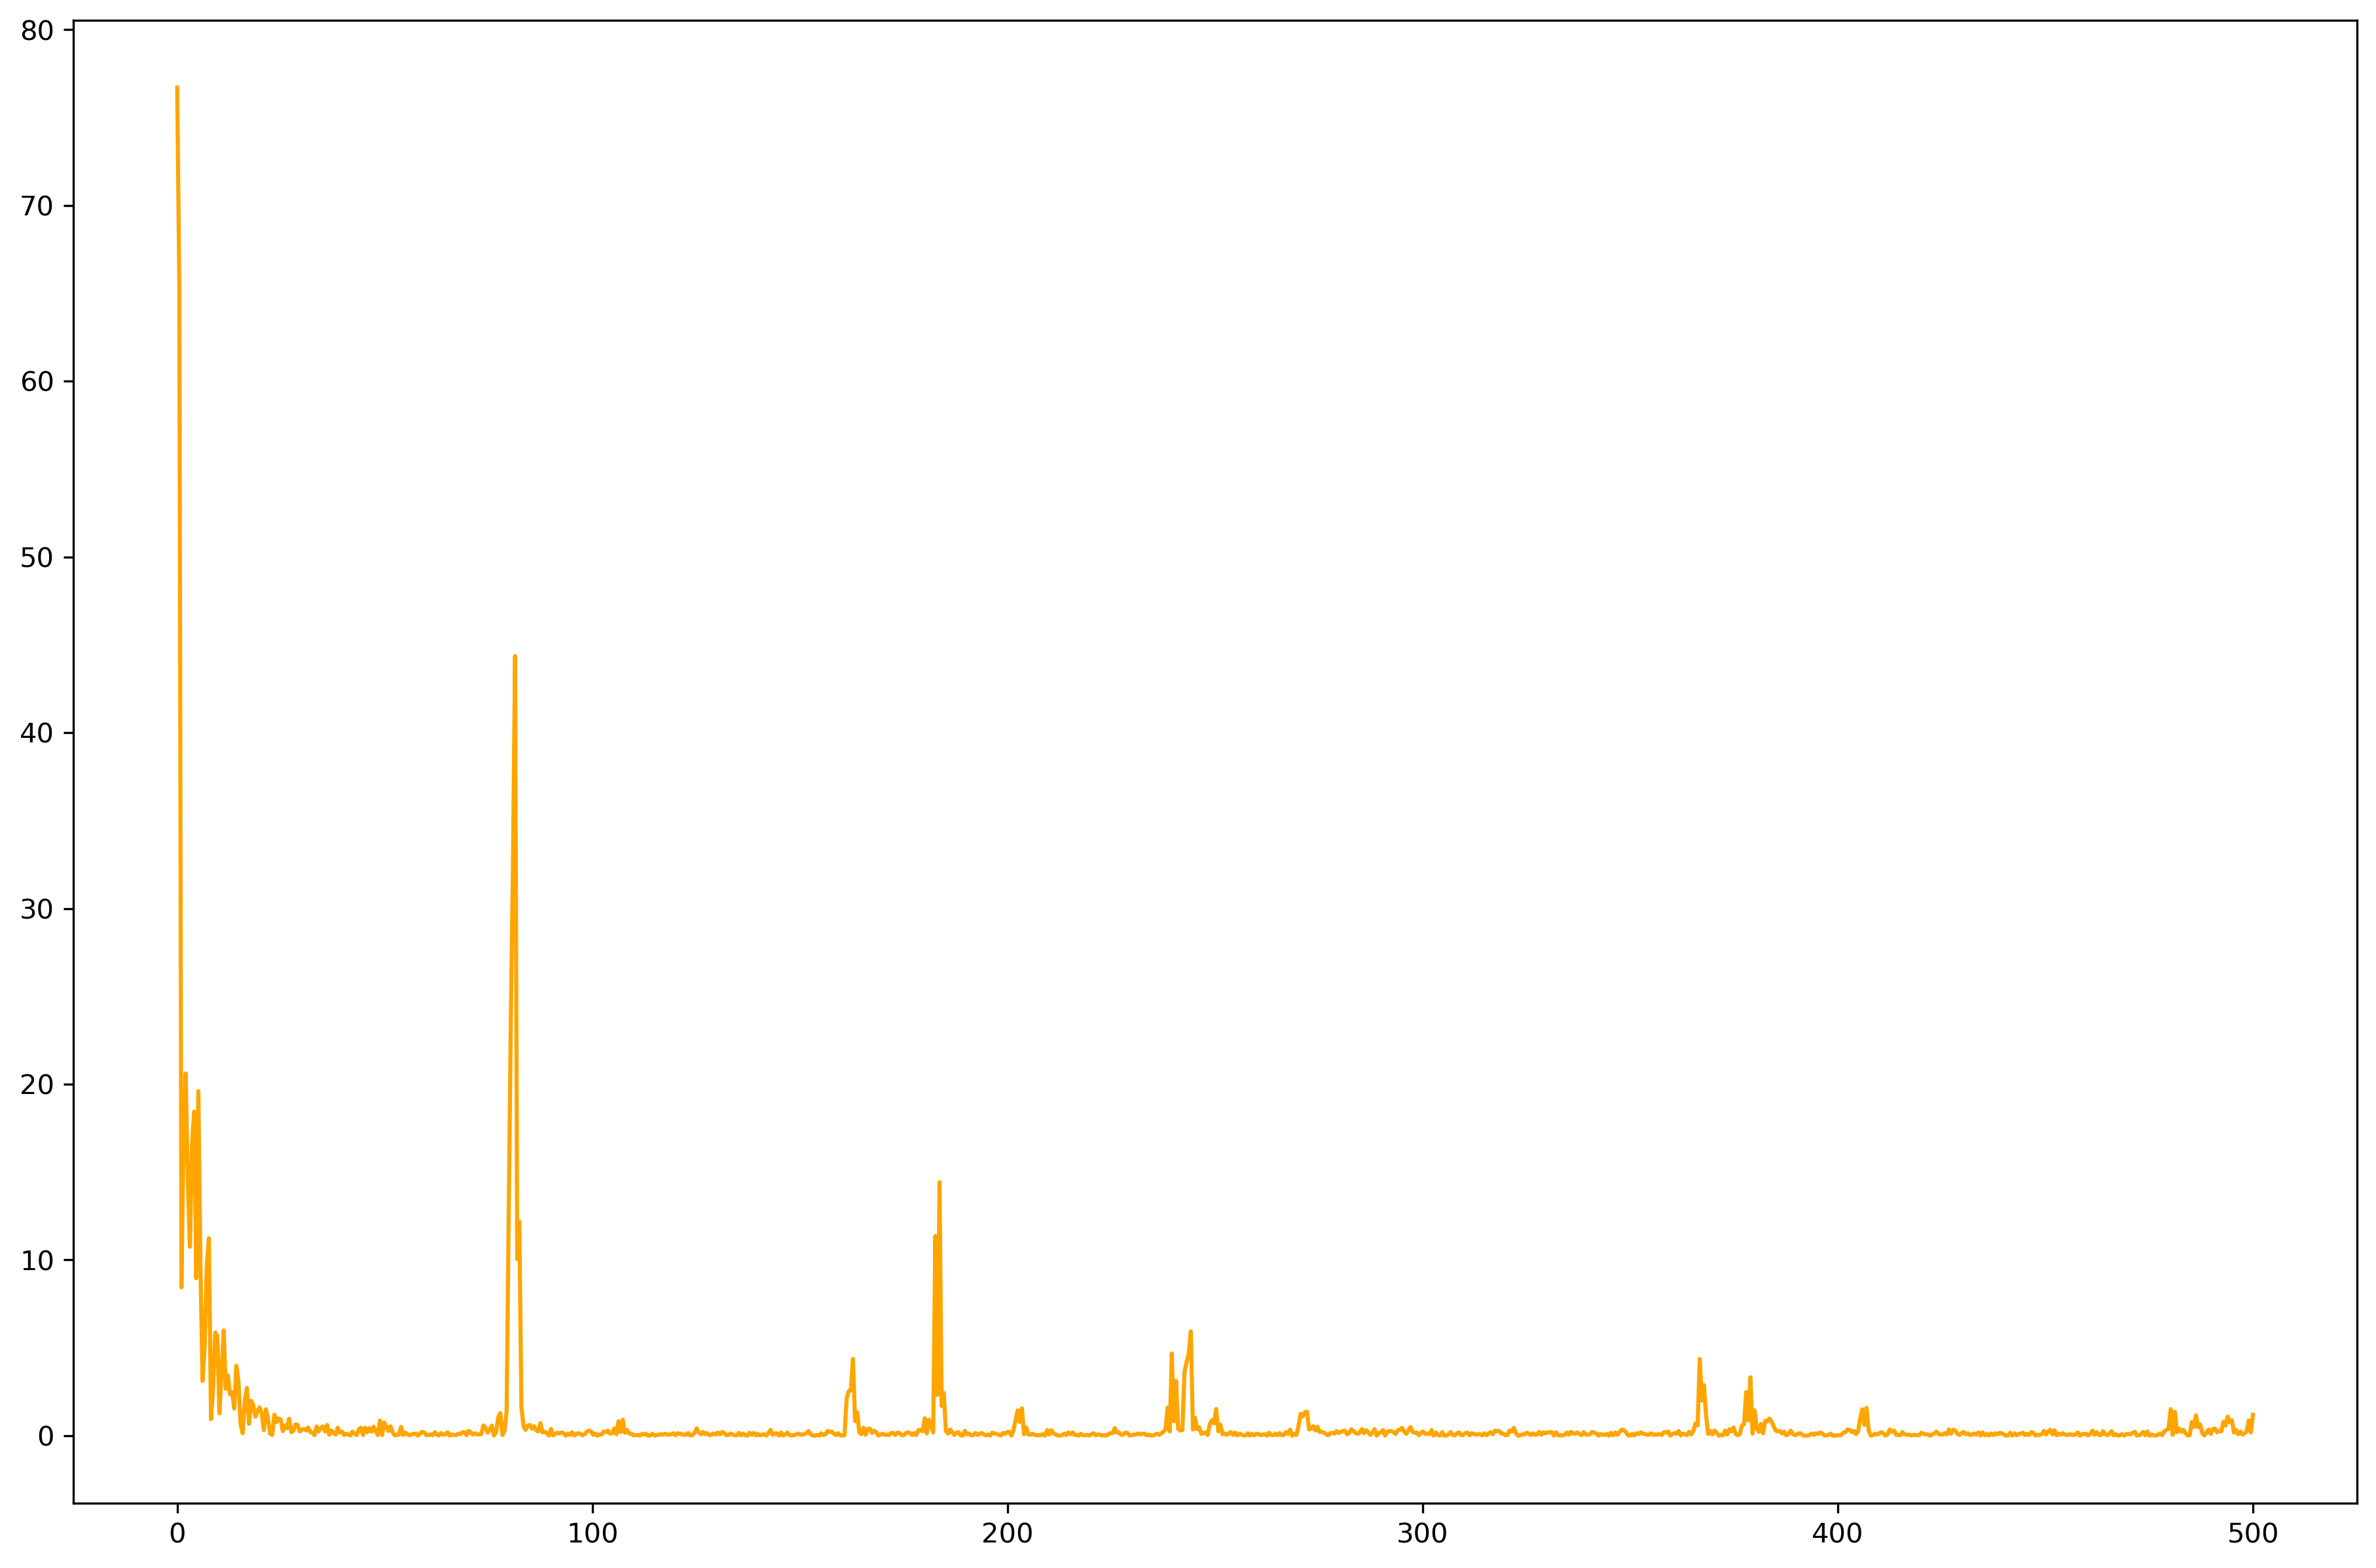

In [4]:
# now apply a hamming window
variable_to_trend = 'current_sub'

y = df[variable_to_trend].to_numpy(dtype='float64')
y = signal.detrend(y,type == 'constant') # Detrended signal
N = len(y) # number of sample points
T = 1.0 / 1000.0 # sample spacing
x = np.linspace(0.0, N*T, N)
y *= np.hamming(N) # apply the window

# frequency of y
yf = fftpack.rfft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig, ax = plt.subplots(figsize=(15,10),dpi=300)
ax.plot(xf, 2.0/N * np.abs(yf[:int(N/2.0)]),color='orange')
plt.show()

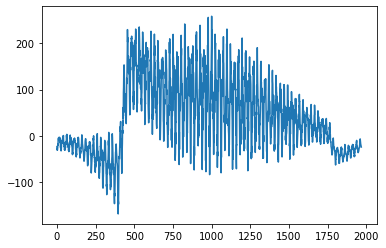

In [41]:
plt.plot(y)

## Stable Speed Signals

In [11]:
# these are files with the "stable speed" selected
interim_data_folder = Path('interim_data_sample/')
file_path = interim_data_folder / '1540298755_54_2.pickle'

# load pickle
with open(file_path, "rb") as input_file:
    df = pickle.load(input_file)

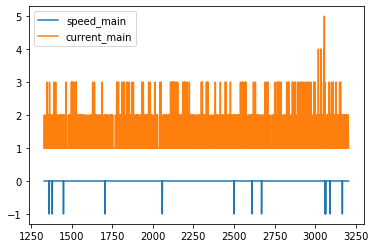

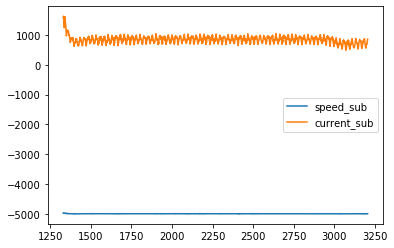

In [12]:
# plot both the main spindle and sub spindle current signals
df.plot(y=['speed_main','current_main'])
df.plot(y=['speed_sub','current_sub'])

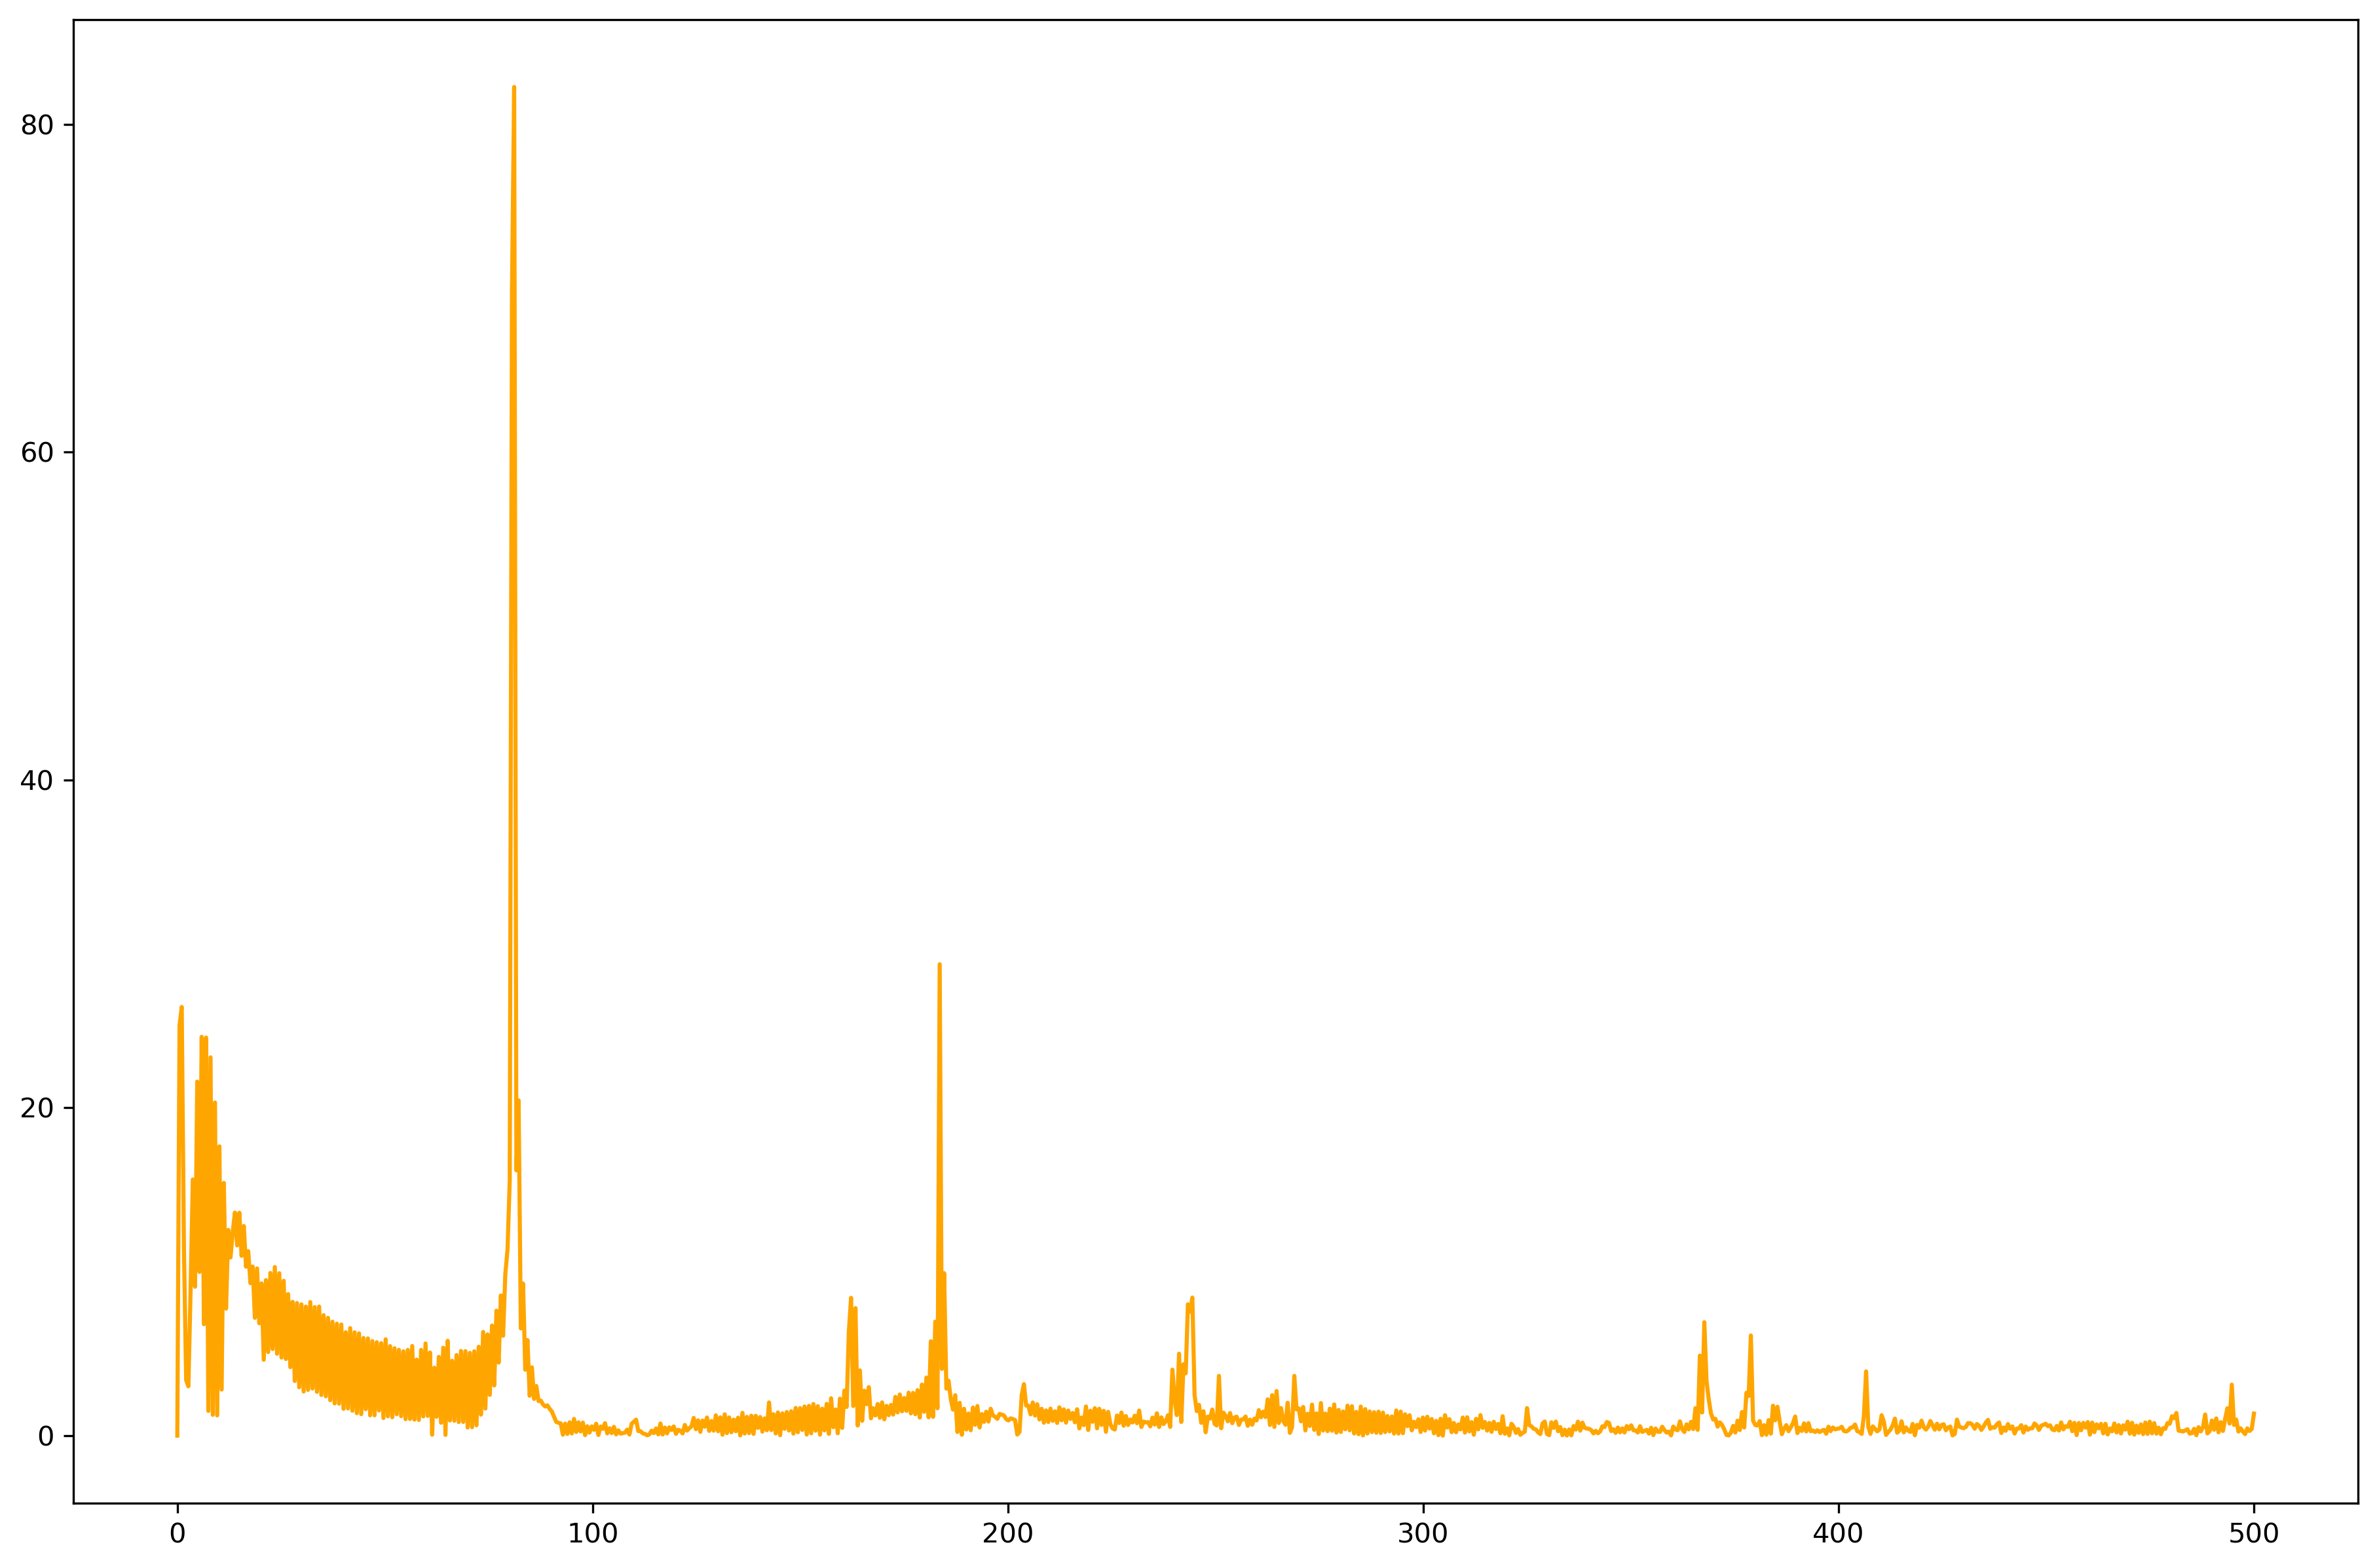

In [13]:
# variable_to_trend = 'Power_SubSpindle'
variable_to_trend = 'current_sub'

y = df[variable_to_trend].to_numpy(dtype='float64')
y = signal.detrend(y,type == 'constant') # Detrended signal
N = len(y) # number of sample points
T = 1.0 / 1000.0 # sample spacing
x = np.linspace(0.0, N*T, N)

# frequency of y
yf = fftpack.rfft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig, ax = plt.subplots(figsize=(15,10),dpi=300)
ax.plot(xf, 2.0/N * np.abs(yf[:int(N/2.0)]),color='orange')
plt.show()


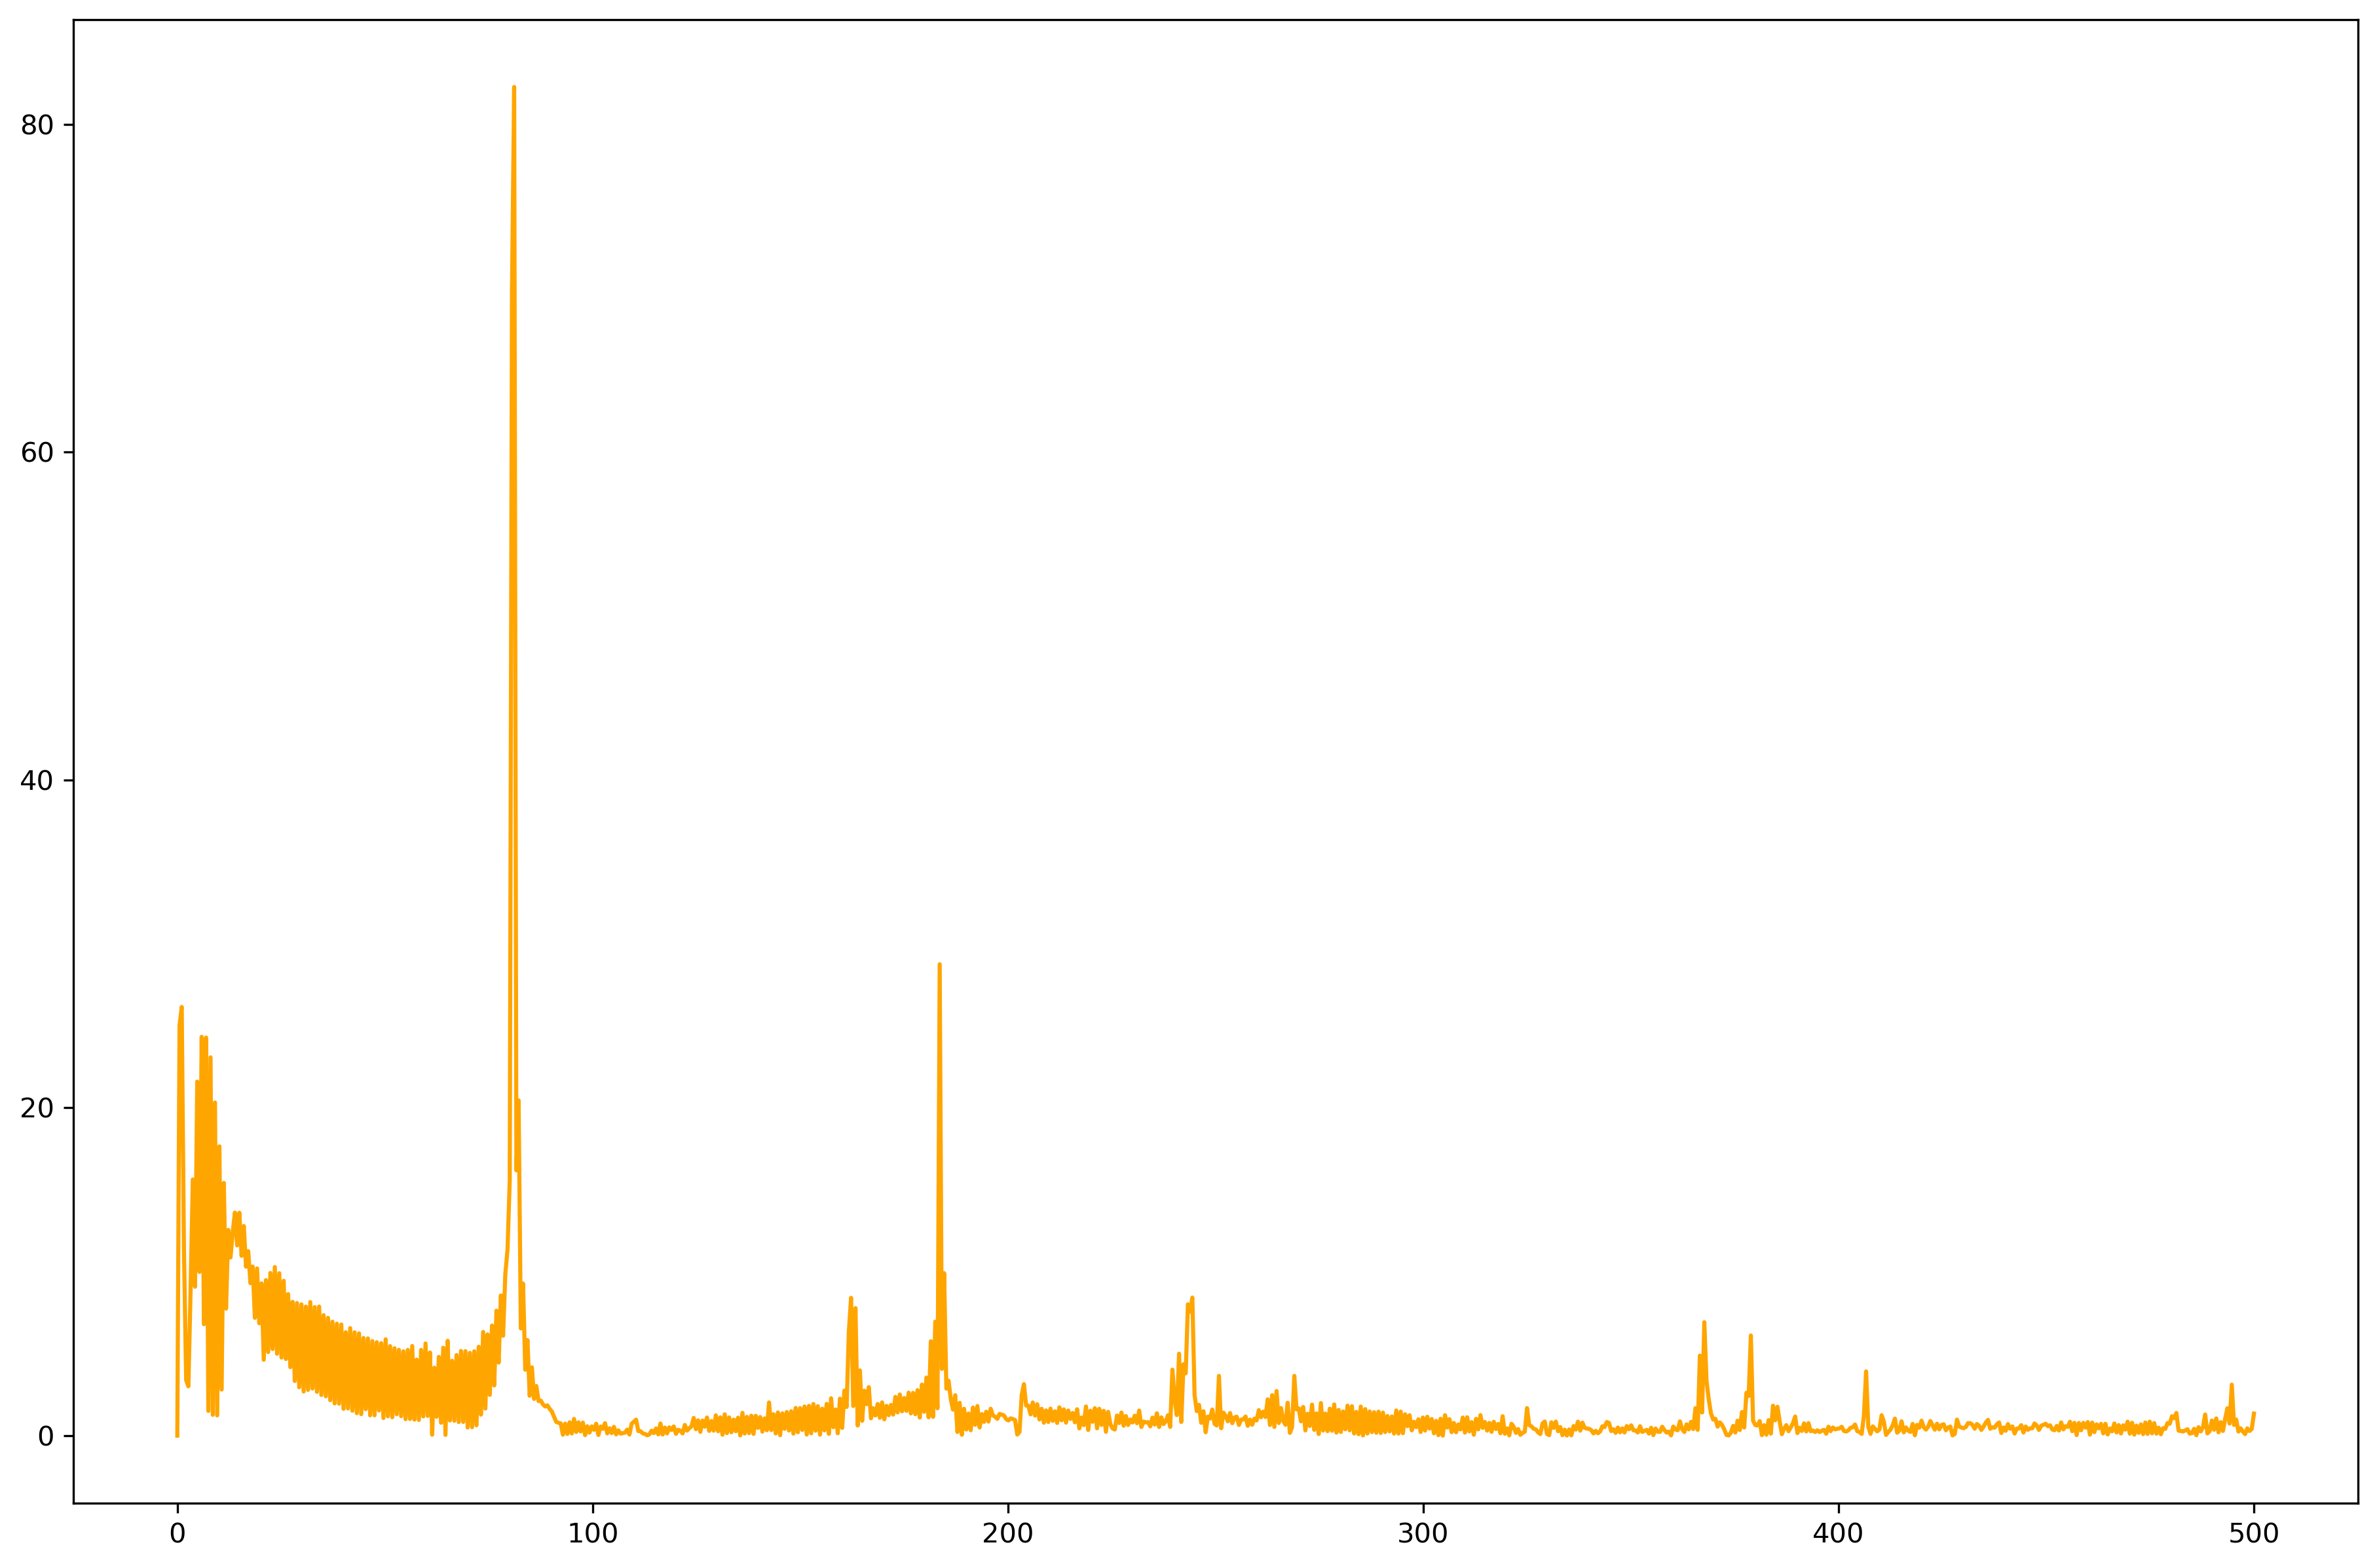

In [14]:
# now apply a hamming window
variable_to_trend = 'current_sub'

y = df[variable_to_trend].to_numpy(dtype='float64')
y = signal.detrend(y,type == 'constant') # Detrended signal
N = len(y) # number of sample points
T = 1.0 / 1000.0 # sample spacing
x = np.linspace(0.0, N*T, N)
x *= np.hamming(N)

# frequency of y
yf = fftpack.rfft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig, ax = plt.subplots(figsize=(15,10),dpi=300)
ax.plot(xf, 2.0/N * np.abs(yf[:int(N/2.0)]),color='orange')
plt.show()

In [104]:
yf.shape

(1877,)

In [105]:
yf = 2.0/N * np.abs(yf[:int(N/2.0)])

In [106]:
yf.shape

(938,)

In [107]:
xf.shape

(938,)

In [108]:
a = np.vstack((yf,xf))
a.shape

(2, 938)

In [110]:
df1 = pd.DataFrame(a.T)
df1.head()

,0,1
0,1.285019e-12,0.000000
1,2.500980e+01,0.533618
2,2.614820e+01,1.067236
3,1.140554e+01,1.600854
4,3.384141e+00,2.134472


In [121]:
def feat_freq_pk_s1(df, signal_name):
    '''Calculate the amplitude of the first harmonic of the cutting frequency'''
    
    y = df[signal_name].to_numpy(dtype='float64')
    y = signal.detrend(y,type == 'constant') # Detrended signal
    N = len(y) # number of sample points
    T = 1.0 / 1000.0 # sample spacing
    x = np.linspace(0.0, N*T, N)
    
    # frequency of y
    yf = fftpack.rfft(y)
    yf = 2.0/N * np.abs(yf[:int(N/2.0)])
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    
    # convert to dataframe for easy manipulation
    df_fft = pd.DataFrame(np.vstack((yf, xf)).T,columns=['amp','freq'])
    
    # select the maximum amplitude below a certain frequency threshold
    pk_s1 = np.max(df_fft['amp'][df_fft['freq'] < 50])
    
    return pk_s1

In [122]:
p = feat_freq_pk_s1(df, 'current_sub')
p

26.148195601110427

In [128]:
def feat_freq_pk_s1_norm(df, signal_name):
    '''Calculate the normalized amplitude of the first harmonic of the cutting frequency'''
    
    y = df[signal_name].to_numpy(dtype='float64')
    y_avg = np.mean(y)
    y = signal.detrend(y,type == 'constant') # Detrended signal
    
    print(y_avg)
    N = len(y) # number of sample points
    T = 1.0 / 1000.0 # sample spacing
    x = np.linspace(0.0, N*T, N)
    
    # frequency of y
    yf = fftpack.rfft(y)
    yf = 2.0/N * np.abs(yf[:int(N/2.0)])
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    
    # convert to dataframe for easy manipulation
    df_fft = pd.DataFrame(np.vstack((yf, xf)).T,columns=['amp','freq'])
    
    # select the maximum amplitude below a certain frequency threshold
    pk_s1_norm = np.max(df_fft['amp'][df_fft['freq'] < 50]) / y_avg
    
    return pk_s1_norm

In [129]:
p = feat_freq_pk_s1_norm(df, 'current_sub')
p

838.8103356419819


0.031172953515287764

In [130]:
def feat_freq_mean(df, signal_name):
    '''Calculate the mean of the of the cutting frequency'''
    
    y = df[signal_name].to_numpy(dtype='float64')
    y = signal.detrend(y,type == 'constant') # Detrended signal
    
    N = len(y) # number of sample points
    T = 1.0 / 1000.0 # sample spacing
    
    # frequency of y
    yf = fftpack.rfft(y)
    yf = 2.0/N * np.abs(yf[:int(N/2.0)])
    
    return np.mean(yf)

In [131]:
p = feat_freq_mean(df, 'current_sub')
p

2.046785412633266

In [133]:
def feat_freq_std(df, signal_name):
    '''Calculate the standard deviation of the cutting frequency'''
    
    y = df[signal_name].to_numpy(dtype='float64')
    y = signal.detrend(y,type == 'constant') # Detrended signal
    
    N = len(y) # number of sample points
    T = 1.0 / 1000.0 # sample spacing
    
    # frequency of y
    yf = fftpack.rfft(y)
    yf = 2.0/N * np.abs(yf[:int(N/2.0)])
    
    return np.std(yf)

In [134]:
p = feat_freq_std(df, 'current_sub')
p

4.773643032305448